In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last" # all | last | last_expr | none 

In [3]:
# for name in dir():
#     if not name.startswith('_'):
#         del globals()[name]

In [4]:
# ============= Import required packaages ==============
import time

# Import all custom variables and modules
from custom_classes_defs.preprocessing import *
# from custom_classes_defs.unet0 import * 
# from custom_classes_defs.Unet_like import *  
from custom_classes_defs.unet import *  
# from custom_classes_defs.fnet0 import *
# from custom_classes_defs.fnet_like import *
# from custom_classes_defs.fnet import *

RND_STATE = 247
BATCH_SIZE = 512
keras.utils.set_random_seed(RND_STATE)
from keras.utils import plot_model

INTERACTIVE_SESSION = True

# -------------------------------------------------------

2024-05-17 23:47:36.746433: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-17 23:47:36.747197: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-17 23:47:36.832664: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-17 23:47:37.029247: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
# Verify tensorflow/keras versions
print(f"tensorflow version: {tf.__version__}")
print(f"keras version: {keras.__version__}")

# Verify CPU/GPU availability
print(tf.config.list_physical_devices())
NUM_GPU = len(tf.config.list_physical_devices('GPU'))
print(f"Number of GPUs assigned for computation: {NUM_GPU}")

if NUM_GPU:
    # print GPU info
    !nvidia-smi

tensorflow version: 2.15.0
keras version: 2.15.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Number of GPUs assigned for computation: 1
/usr/local/bin/bash: /opt/miniconda3-py311/lib/libtinfo.so.6: no version information available (required by /usr/local/bin/bash)


Fri May 17 23:48:05 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:01:00.0 Off |                    0 |
| N/A   27C    P0              58W / 400W |    704MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

|   2  NVIDIA A100-SXM4-40GB          Off | 00000000:81:00.0 Off |                    0 |
| N/A   26C    P0              51W / 400W |      0MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+----------------------+
|   3  NVIDIA A100-SXM4-40GB          Off | 00000000:C1:00.0 Off |                    0 |
| N/A   25C    P0              56W / 400W |      0MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+----------------------+
                                                                                         
+---------------------------------------------------------------------------------------+
| Processes:                                                                            |
|  GPU   G

### Data preparation and model configurations

In [6]:
print("{}\n\t{}\n{}".format('='*55,'Data preparation and model configurations', '-'*55))
# Hand-written alphabet images
start = time.time()
if 'letters' not in dir():
    letters = MNIST_letters(
        './data/az_handwritten_alphabets_in_csv_format/A_Z_Handwritten_Data.csv',
    )
    
# # Preprocessing and normalization

# Load data (split ratio = train:val:test = 5:1:4)
(x_train, _), (x_test, _), (x_val, _) = \
    letters.split_data(train_ratio=0.5, val_ratio=0.1)

print("Shape of dataset: {}".format(str(letters.df.shape)))
print("Shape of training data: {}".format(str(x_train.shape)))
print("Shape of validation data: {}".format(str(x_val.shape)))
print("Shape of test data: {}".format(str(x_test.shape))) 

# Create data generator for respective data samples and labels
train_dataset = letters.data_generator(x_train, batch_size=BATCH_SIZE, cache=NUM_GPU) 
val_dataset = letters.data_generator(x_val, batch_size=BATCH_SIZE, cache=NUM_GPU) 
x_test, y_test = letters.data_generator(x_test, as_numpy=True)
        
print("Train Dataset:", train_dataset)
print('...elapsed time: ___{:5.2f} minutes___'.format((time.time()-start) / 60))

	Data preparation and model configurations
-------------------------------------------------------


Shape of dataset: (144013, 784)
Shape of training data: (72006, 28, 28)
Shape of validation data: (14402, 28, 28)
Shape of test data: (57605, 28, 28)


2024-05-17 23:48:28.521176: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38379 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:41:00.0, compute capability: 8.0


Train Dataset: <CacheDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 28, 28, 1), dtype=tf.uint8, name=None))>
...elapsed time: ___ 0.33 minutes___


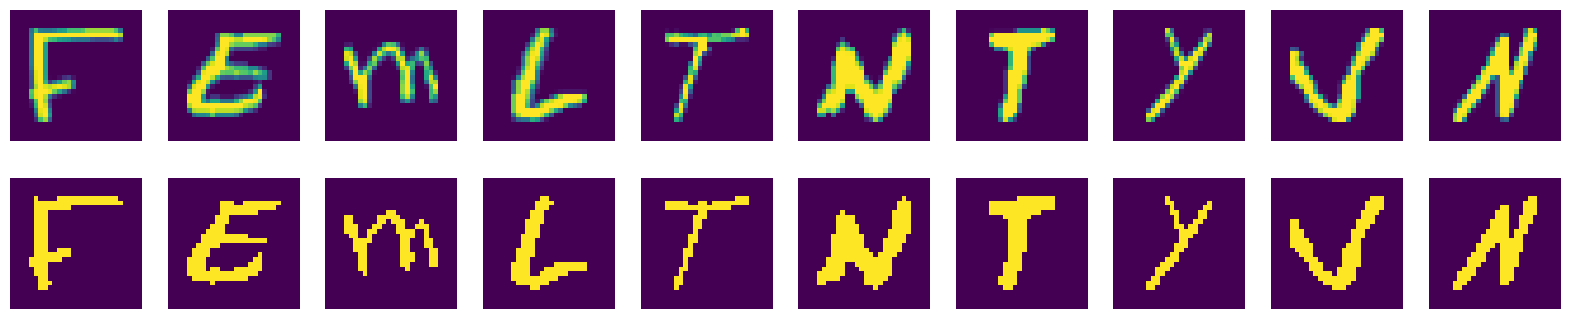

In [7]:
display_sample_images(x_test, y_test, img_shape=(28,28))

In [8]:

# Model configurations
conf = model_config(
    epochs=100,
    batch_size=BATCH_SIZE,
    shuffle=True,
    scaling=1,
    save_path='./mnist-letters/unet',
    threshold=letters.threshold,
    pos_label=letters.pos_label,
    new_training_session=True,
    multiple_gpu_device=(NUM_GPU>1),
    train_size=letters.train_size,
    test_size=letters.test_size,
    validation_size=letters.validation_size
)

callbacks = conf.callbacks(
    chkpt_monitor='val_f1_score', 
    es_monitor='val_loss',
    es_patience=15, 
    lr_monitor='val_loss',
    lr_patience=5,
)

conf.set( validation_data=val_dataset,  callbacks=callbacks )
m1 = f1_score(positive_label=letters.pos_label, threshold=letters.threshold)
conf.set(
    'compile',
    metrics= ['accuracy', m1]
)

# conf.double_check(INTERACTIVE_SESSION)
conf.info()

             NUM_GPU: 1
        compile_args:
                     optimizer: adam
                          loss: binary_crossentropy
                       metrics: accuracy
                              : f1_score(name=f1_score,dtype=float32)
              labels: ListWrapper([0, 1])
     mixed_precision: None
          model_arch:
                     img_shape: (28, 28)
                   target_size: (28, 28)
                  channels_dim: (1, 1)
                       scaling: 1
                  augmentation: False
 multiple_gpu_device: False
new_training_session: True
           pos_label: 1
           save_path: ./mnist-letters/unet
           test_size: 57605
           threshold: 0.5
          train_size: 72006
       training_args:
                        epochs: 100
                    batch_size: 512
                       shuffle: True
                       verbose: 0
               validation_data: <class 'tensorflow.python.data.ops.cache_op.CacheDataset'>
          

### Build  model 

In [9]:
print("\n\n{}\n\t{}\n{}".format('='*55,f'Build model', '-'*55))

if conf.multiple_gpu_device:

    strategy = tf.distribute.MirroredStrategy()
    print(f"Number of devices: {strategy.num_replicas_in_sync}")
    with strategy.scope():
        m_obj = UNET2D(panel_sizes=[32,64,128,256], model_arch=conf.model_arch)
        # m_obj = FNET2D(panel_sizes=[32,64,128,256], model_arch=conf.model_arch)
        model = m_obj.build_model()
        model.compile(**conf.compile_args)

else:

    m_obj = UNET2D(panel_sizes=[32,64,128,256], model_arch=conf.model_arch)
    # m_obj = FNET2D(panel_sizes=[32,64,128,256], model_arch=conf.model_arch)
    model = m_obj.build_model()
    model.compile(**conf.compile_args)


# model.summary()
# keras.utils.plot_model(model, 'm_obj.png',show_shapes=True)
# plot_model(model, 'm_obj.png',show_shapes=True)
num_trainable_weights = sum([np.prod(w.shape) for w in model.trainable_weights])
print(f"Total number of parameters: {model.count_params():,}")
print(f"Total trainable wieghts: {num_trainable_weights:,}")
print(f"Total non-trainable wieghts: {model.count_params()-num_trainable_weights:,}")





	Build model
-------------------------------------------------------
inputs padded by 2 to fit model design


Cropping the output by 2 to fit input...
Total number of parameters: 1,845,409
Total trainable wieghts: 1,842,593
Total non-trainable wieghts: 2,816


### Train  model



	Train unet model
-------------------------------------------------------
Model training...


2024-05-17 23:48:49.085546: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inU-NET/sequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2024-05-17 23:48:50.106555: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907


2024-05-17 23:49:01.008865: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f42e0806070 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-17 23:49:01.008933: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2024-05-17 23:49:01.108625: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


I0000 00:00:1715982542.059139 3343094 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 54: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.



Epoch 59: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.



Epoch 64: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.


training elapsed time: ___5.47 ___ minutes
...training completed!


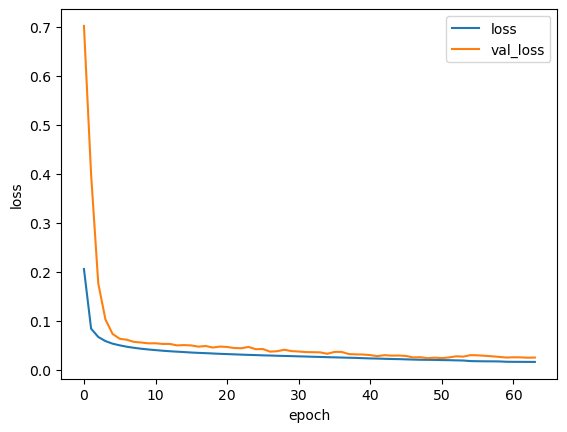

In [10]:
print("\n\n{}\n\t{}\n{}".format('='*55,f'Train {m_obj.Name} model', '-'*55))

model, train_history = \
    conf.execute_training(
        model, 
        data=train_dataset, 
        plot_history=INTERACTIVE_SESSION
)


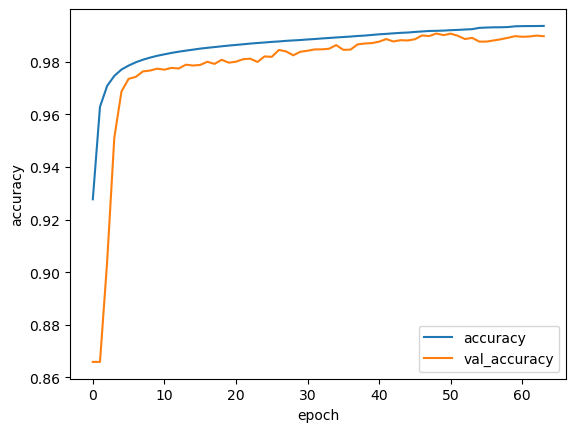

In [11]:
show_convergence(train_history.history, ['accuracy','val_accuracy'])

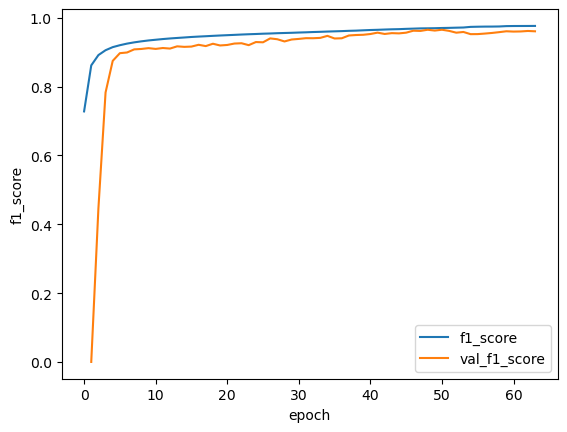

In [12]:
show_convergence(train_history.history, ['f1_score','val_f1_score'])

### Evaluate and Vizualize

In [13]:
print("\n\n{}\n\t{}\n{}".format('='*55,f'Evaluate {m_obj.Name} model', '-'*55))
decoded_imgs = model.predict(x_test)




	Evaluate unet model
-------------------------------------------------------


   1/1801 [..............................] - ETA: 26:13

  13/1801 [..............................] - ETA: 7s   

  25/1801 [..............................] - ETA: 7s

  38/1801 [..............................] - ETA: 7s

  50/1801 [..............................] - ETA: 7s

  63/1801 [>.............................] - ETA: 7s

  77/1801 [>.............................] - ETA: 7s

  90/1801 [>.............................] - ETA: 6s

 103/1801 [>.............................] - ETA: 6s

 116/1801 [>.............................] - ETA: 6s

 129/1801 [=>............................] - ETA: 6s

 143/1801 [=>............................] - ETA: 6s

 157/1801 [=>............................] - ETA: 6s

 170/1801 [=>............................] - ETA: 6s

 183/1801 [==>...........................] - ETA: 6s

 196/1801 [==>...........................] - ETA: 6s

 211/1801 [==>...........................] - ETA: 6s

 225/1801 [==>...........................] - ETA: 6s

 238/1801 [==>...........................] - ETA: 6s

 252/1801 [===>..........................] - ETA: 6s

 266/1801 [===>..........................] - ETA: 6s

 279/1801 [===>..........................] - ETA: 5s

 292/1801 [===>..........................] - ETA: 5s

 304/1801 [====>.........................] - ETA: 5s

 318/1801 [====>.........................] - ETA: 5s

 332/1801 [====>.........................] - ETA: 5s

 346/1801 [====>.........................] - ETA: 5s

 359/1801 [====>.........................] - ETA: 5s

 373/1801 [=====>........................] - ETA: 5s

 386/1801 [=====>........................] - ETA: 5s

 399/1801 [=====>........................] - ETA: 5s

 412/1801 [=====>........................] - ETA: 5s

 425/1801 [======>.......................] - ETA: 5s

 438/1801 [======>.......................] - ETA: 5s

 451/1801 [======>.......................] - ETA: 5s

 465/1801 [======>.......................] - ETA: 5s

 479/1801 [======>.......................] - ETA: 5s

 491/1801 [=======>......................] - ETA: 5s

 504/1801 [=======>......................] - ETA: 5s

 517/1801 [=======>......................] - ETA: 5s

 531/1801 [=======>......................] - ETA: 4s

 544/1801 [========>.....................] - ETA: 4s

 558/1801 [========>.....................] - ETA: 4s

 572/1801 [========>.....................] - ETA: 4s

 585/1801 [========>.....................] - ETA: 4s

 598/1801 [========>.....................] - ETA: 4s

 612/1801 [=========>....................] - ETA: 4s

 625/1801 [=========>....................] - ETA: 4s

 638/1801 [=========>....................] - ETA: 4s

 651/1801 [=========>....................] - ETA: 4s

 664/1801 [==========>...................] - ETA: 4s

 678/1801 [==========>...................] - ETA: 4s

 691/1801 [==========>...................] - ETA: 4s

 703/1801 [==========>...................] - ETA: 4s

 718/1801 [==========>...................] - ETA: 4s

 731/1801 [===========>..................] - ETA: 4s

 744/1801 [===========>..................] - ETA: 4s

 757/1801 [===========>..................] - ETA: 4s

 771/1801 [===========>..................] - ETA: 4s

 784/1801 [============>.................] - ETA: 3s

 797/1801 [============>.................] - ETA: 3s

 810/1801 [============>.................] - ETA: 3s

 824/1801 [============>.................] - ETA: 3s

 837/1801 [============>.................] - ETA: 3s

 850/1801 [=============>................] - ETA: 3s

 863/1801 [=============>................] - ETA: 3s

 876/1801 [=============>................] - ETA: 3s

 889/1801 [=============>................] - ETA: 3s

 903/1801 [==============>...............] - ETA: 3s

 916/1801 [==============>...............] - ETA: 3s

 929/1801 [==============>...............] - ETA: 3s

 942/1801 [==============>...............] - ETA: 3s

 955/1801 [==============>...............] - ETA: 3s

 968/1801 [===============>..............] - ETA: 3s

 981/1801 [===============>..............] - ETA: 3s

 994/1801 [===============>..............] - ETA: 3s

1007/1801 [===============>..............] - ETA: 3s

1020/1801 [===============>..............] - ETA: 3s

1033/1801 [================>.............] - ETA: 3s

1047/1801 [================>.............] - ETA: 2s

1060/1801 [================>.............] - ETA: 2s

1074/1801 [================>.............] - ETA: 2s

1089/1801 [=================>............] - ETA: 2s

1104/1801 [=================>............] - ETA: 2s

1119/1801 [=================>............] - ETA: 2s

1132/1801 [=================>............] - ETA: 2s

1147/1801 [==================>...........] - ETA: 2s

1160/1801 [==================>...........] - ETA: 2s

1175/1801 [==================>...........] - ETA: 2s

1188/1801 [==================>...........] - ETA: 2s

1201/1801 [===================>..........] - ETA: 2s

1214/1801 [===================>..........] - ETA: 2s

1230/1801 [===================>..........] - ETA: 2s

1244/1801 [===================>..........] - ETA: 2s

1257/1801 [===================>..........] - ETA: 2s

1270/1801 [====================>.........] - ETA: 2s

1281/1801 [====================>.........] - ETA: 2s

1294/1801 [====================>.........] - ETA: 1s

1308/1801 [====================>.........] - ETA: 1s

1321/1801 [=====================>........] - ETA: 1s

1334/1801 [=====================>........] - ETA: 1s

1348/1801 [=====================>........] - ETA: 1s

1361/1801 [=====================>........] - ETA: 1s

1374/1801 [=====================>........] - ETA: 1s

1387/1801 [======================>.......] - ETA: 1s

1400/1801 [======================>.......] - ETA: 1s

1414/1801 [======================>.......] - ETA: 1s

1427/1801 [======================>.......] - ETA: 1s

1441/1801 [=======================>......] - ETA: 1s

1456/1801 [=======================>......] - ETA: 1s

1470/1801 [=======================>......] - ETA: 1s

1484/1801 [=======================>......] - ETA: 1s

1496/1801 [=======================>......] - ETA: 1s

1509/1801 [========================>.....] - ETA: 1s

1521/1801 [========================>.....] - ETA: 1s

1535/1801 [========================>.....] - ETA: 1s

1549/1801 [========================>.....] - ETA: 0s

1563/1801 [=========================>....] - ETA: 0s

1576/1801 [=========================>....] - ETA: 0s

1592/1801 [=========================>....] - ETA: 0s

1607/1801 [=========================>....] - ETA: 0s

1620/1801 [=========================>....] - ETA: 0s

1633/1801 [==========================>...] - ETA: 0s

1647/1801 [==========================>...] - ETA: 0s

1659/1801 [==========================>...] - ETA: 0s

1671/1801 [==========================>...] - ETA: 0s

1683/1801 [===========================>..] - ETA: 0s

1696/1801 [===========================>..] - ETA: 0s

1709/1801 [===========================>..] - ETA: 0s

1722/1801 [===========================>..] - ETA: 0s

1734/1801 [===========================>..] - ETA: 0s

1747/1801 [============================>.] - ETA: 0s

1761/1801 [============================>.] - ETA: 0s

1774/1801 [============================>.] - ETA: 0s

1788/1801 [============================>.] - ETA: 0s

1801/1801 [==============================] - ETA: 0s

1801/1801 [==============================] - 8s 4ms/step


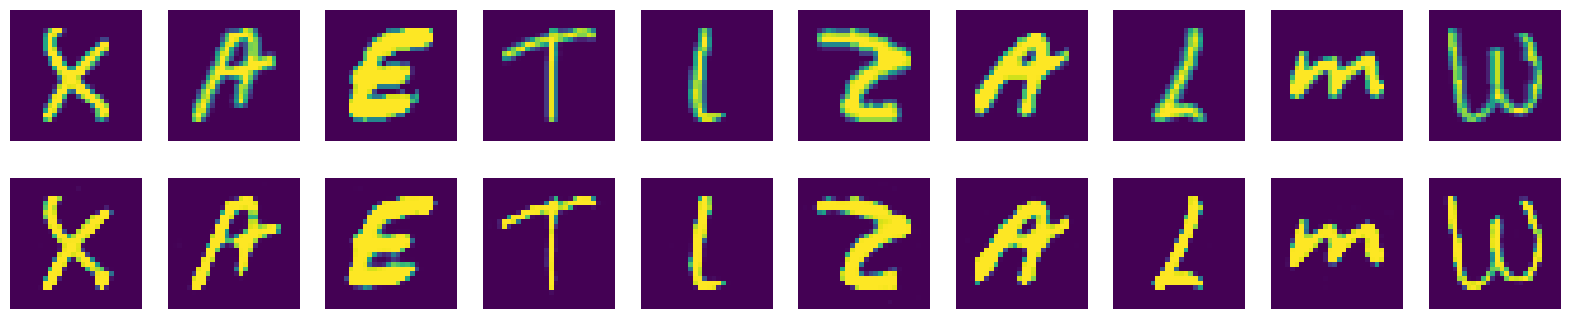

In [14]:

if INTERACTIVE_SESSION:
    display_sample_images(x_test, decoded_imgs, conf.img_shape)
    

In [15]:
model.evaluate(x=x_test)


   1/1801 [..............................] - ETA: 9:15 - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

  31/1801 [..............................] - ETA: 3s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan  

  60/1801 [..............................] - ETA: 3s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

  90/1801 [>.............................] - ETA: 2s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 121/1801 [=>............................] - ETA: 2s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 153/1801 [=>............................] - ETA: 2s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 184/1801 [==>...........................] - ETA: 2s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 215/1801 [==>...........................] - ETA: 2s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 246/1801 [===>..........................] - ETA: 2s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 277/1801 [===>..........................] - ETA: 2s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 310/1801 [====>.........................] - ETA: 2s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 341/1801 [====>.........................] - ETA: 2s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 372/1801 [=====>........................] - ETA: 2s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 401/1801 [=====>........................] - ETA: 2s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 431/1801 [======>.......................] - ETA: 2s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 461/1801 [======>.......................] - ETA: 2s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 491/1801 [=======>......................] - ETA: 2s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 521/1801 [=======>......................] - ETA: 2s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 551/1801 [========>.....................] - ETA: 2s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 581/1801 [========>.....................] - ETA: 2s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 610/1801 [=========>....................] - ETA: 1s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 641/1801 [=========>....................] - ETA: 1s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 671/1801 [==========>...................] - ETA: 1s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 701/1801 [==========>...................] - ETA: 1s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 731/1801 [===========>..................] - ETA: 1s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 761/1801 [===========>..................] - ETA: 1s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 791/1801 [============>.................] - ETA: 1s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 821/1801 [============>.................] - ETA: 1s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 849/1801 [=============>................] - ETA: 1s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 880/1801 [=============>................] - ETA: 1s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 911/1801 [==============>...............] - ETA: 1s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 942/1801 [==============>...............] - ETA: 1s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 973/1801 [===============>..............] - ETA: 1s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1003/1801 [===============>..............] - ETA: 1s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1033/1801 [================>.............] - ETA: 1s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1064/1801 [================>.............] - ETA: 1s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1094/1801 [=================>............] - ETA: 1s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1124/1801 [=================>............] - ETA: 1s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1155/1801 [==================>...........] - ETA: 1s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1186/1801 [==================>...........] - ETA: 1s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1217/1801 [===================>..........] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1248/1801 [===================>..........] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1279/1801 [====================>.........] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1310/1801 [====================>.........] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1341/1801 [=====================>........] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1372/1801 [=====================>........] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1402/1801 [======================>.......] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1433/1801 [======================>.......] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1464/1801 [=======================>......] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1495/1801 [=======================>......] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1526/1801 [========================>.....] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1557/1801 [========================>.....] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1588/1801 [=========================>....] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1620/1801 [=========================>....] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1651/1801 [==========================>...] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1682/1801 [===========================>..] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1713/1801 [===========================>..] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1744/1801 [============================>.] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1775/1801 [============================>.] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1801/1801 [==============================] - 3s 2ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan


[0.0, 0.0, nan]

In [16]:

scores = conf.evaluate_sklearn(y_test, decoded_imgs,report=True)
print(scores)

evaluation elapsed time:___ 1.38___minutes
                     0           1  accuracy    macro avg  weighted avg
precision         1.00        0.27      0.63         0.63          0.90
recall            0.58        1.00      0.63         0.79          0.63
f1-score          0.73        0.42      0.63         0.58          0.69
support    39130264.00  6032056.00      0.63  45162320.00   45162320.00
{'Avg-precision': 1.0, 'f1-score(ODS)': 0.42}
